#Lecture 13: Timeseries and Nonlinear PCA

In the last two lectures, we did PCA/ICA across variables in a multivariate timeseries.  In other words, when $x(t) \in R^N$ is a vector, PCA finds another smaller timeseries $y(t) \in R^M, M<<N$.  ICA finds a timeseries of the same size $y(t) \in R^N$ in which the elements $y_i(t)$ are independent of each other.

Here we will look at compressing across time, rather than at individual time points $t$.   In other words, we will find a compressed representation of $<x(t), x(t-1), \ldots , x(t-N)>$ which will apply even when $x(t)$ is scalar.  Let's assume for the moment this is a scalar, and call the vector of past values $x_{t-N}^t$.  Then for PCA, we seek a transformation $y(t) = Wx_{t-N}^t$ such that $y(t) \in R^M$ has maximum variance (subject to $W$ being an orthonormal matrix where $W^TW = I$).  

Note that $y(t)$ is now a multivariate timeseries, even when $x(t)$ is scalar.  So this really is not data compression, unless we subsample.  For instance we could decide that $y(t)$ represents all the data we will use from $x(t) \ldots x(t-N)$, in which case we only need to calculate $y(t)$ every $N$ steps (ie: $y(kN)$ for integer $k$).  But another use is for calculating filters.  An arbitrary $N$-point FIR filter has $N$ coefficients and calculates $\sum_{\tau=t-N}^t h(t-\tau)x(\tau)$ which we could write as $h^Tx_{t-N}^t$.  We could approximate $h \approx  W \alpha$ where $W$ is an $M \times N$ matrix whose columns are the first $M$ eigenvectors of $E[x_{t-N}^t(x_{t-N}^t)^T]$, and where $\alpha$ is a vector of $M$ coefficients chosen to approximate $h$.  Thus the filter is now specified by $M$ rather than $N$ coefficients, and the VARIMAX property of PCA specifies that the resulting approximation to $h$ is as good as possible (under the assumption that the components of $\alpha$ are i.i.d. Gaussian and the goal is minimizing the MSE $E_{x,\alpha}[(h^Tx - \hat{h}^Tx)^2]$). 

In [1]:
#The usual preamble
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

import tensorflow as tf
from scipy import signal

#for your homework
np.random.seed(10327798)
tf.random.set_seed(10327798)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We will use the brain recording data again.  3 channels recorded from nearby sites in the GPi brain region.  Recordings at 24kHz, values in uV.

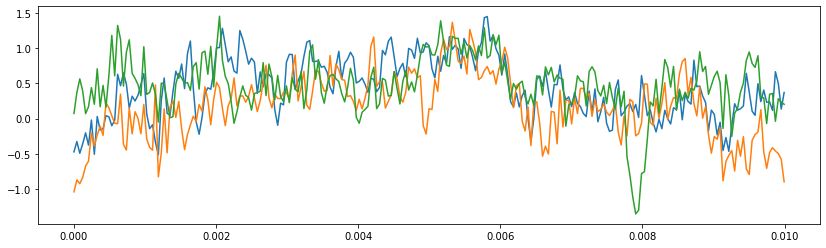

In [3]:
#load the sample Brain data
#3 channels from GPi, each in microvolts.  sampling at 24.414kHz
micro123 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/micro123.csv', names=['ch1','ch2','ch3'])
nDims=3
samplingFrequency = 24414
nPoints = len(micro123)
maxTime = nPoints/samplingFrequency
ts_index = np.linspace(start= 0 ,stop=maxTime, num= nPoints)

#scale the range.  scale separately for each of the 3 data channels
from sklearn.preprocessing import StandardScaler   #use standard normal (mean 0, std 1) rather than min/max scaler here
scaler = StandardScaler()
scaler.fit(micro123)  
micro123_scaled = scaler.transform(micro123)  
dfMic = pd.DataFrame(micro123_scaled, index = ts_index)  #make a dataframe

plt.figure(figsize=(14,4))
plt.plot(dfMic[0:.01]);

Will use a timeseriesgenerator object here, although I'm going to ignore the "y" output value and just use the "x" input values.

In [4]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
predict_length = 4 * int(samplingFrequency/1000.0)  #4 msec
gen = TimeseriesGenerator(dfMic.values, dfMic.values, length =predict_length , batch_size=1) 
gen[0][0].shape

(1, 96, 3)

4msec = 96 points, and 3 channels.  Therefore 96x3 input.  The "1" is the batch size.

In [5]:
from tensorflow.python.keras.engine.base_layer_utils import uses_keras_history
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Permute, AveragePooling2D, Concatenate
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, LayerNormalization, SimpleRNN
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D, ConvLSTM2D, LSTM, Input
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping

TimeSeriesGenerator takes a multi-time input $x(t),\ldots,x(t-N)$ and a single-time output $y(t)$ to train the network for y=f(x).  But for an autoencoder, we need the output to be the same as the input $x(t),\ldots,x(t-N)$. One way to do this would be to modify (subclass) TimeSeriesGenerator to allow this as an option.  Another (which I will do) is to modify the Model.fit() routine to ignore the $y(t)$ passed in and use the input $x(t),\ldots,x(t-N)$ as the target instead.  This assumes that the model has been built with the same number of outputs as inputs, in the same shape.  

The subclass code is taken from the following webiste:
https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit


In [6]:
#Create a subclass of keras.Model that learns auto-encoding
class AutoEncoderModel(Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data
        y = x ###for autoencoder; ignore target supplied by timeseriesgenerator; this is the only change to the code.

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1, 96, 3)]        0         
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                                 
 encode (Dense)              (None, 8)                 2312      
                                                                 
 decode (Dense)              (None, 288)               2592      
                                                                 
 reshape (Reshape)           (None, 96, 3)             0         
                                                                 
Total params: 4,904
Trainable params: 4,904
Non-trainable params: 0
_________________________________________________________________


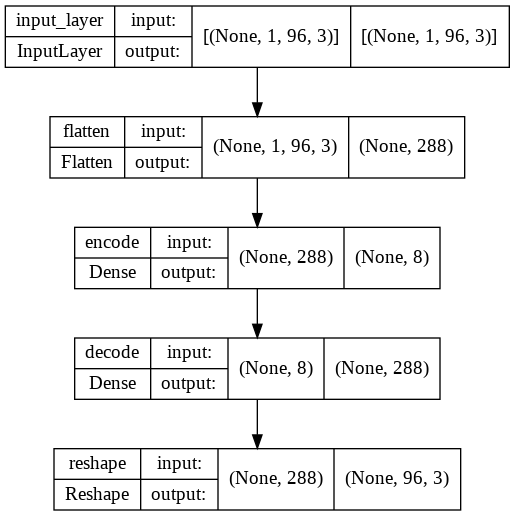

In [7]:
#build a simple linear autoencoder network
n_hidden_units1 = 8    
batch_size1 = 1

input_layer = Input(shape=(batch_size1, predict_length, nDims), name='input_layer')
flatten_layer = Flatten()(input_layer)  #have to flatten the 96x3 input in order to learn the eigenvectors
encode_layer = Dense(units=n_hidden_units1, activation='linear', name='encode')(flatten_layer)
decode_layer = Dense(units=nDims*predict_length, activation='linear', name='decode')(encode_layer)
reshape_layer = Reshape((predict_length, nDims))(decode_layer)
output_layer = reshape_layer

#use the AutoencoderModel
model1 = AutoEncoderModel(inputs = input_layer, outputs = output_layer, name ='model1')  #have to explicitly tell it the inputs and outputs
model1.compile(optimizer='adam', loss='mse')
model1.summary()
plot_model(model1, show_shapes = True, show_layer_names = True)

The first network takes the 96 time points x 3 sensors and creates a single 288-element vector.  The linear encoder attempts to compress this to 8 values with maximum variance.

Epoch 1/5
99904/99904 [==============================] - 210s 2ms/step - loss: 0.1355
Epoch 2/5
99904/99904 [==============================] - 210s 2ms/step - loss: 0.1326
Epoch 3/5
99904/99904 [==============================] - 206s 2ms/step - loss: 0.1327
Epoch 4/5
99904/99904 [==============================] - 203s 2ms/step - loss: 0.1327
Epoch 5/5
99904/99904 [==============================] - 211s 2ms/step - loss: 0.1329


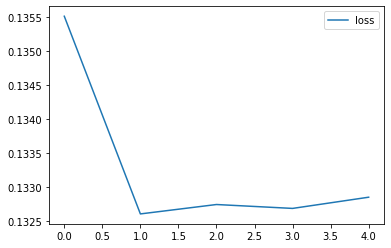

In [8]:
#we can use gen (timeseriesgenerator) here because AutoEncoderModel will ignore the output y and use the input as the target instead.
model1.fit(gen,epochs=5)
losses = pd.DataFrame(model1.history.history)
losses.plot()

Now, let's look at the weights that were learned.  The weights to each output come from each of the 3 dimensions at each of the 96 time points.  By reshaping, we can figure out what the filter looks like for each output and each input.

(96, 3, 8)


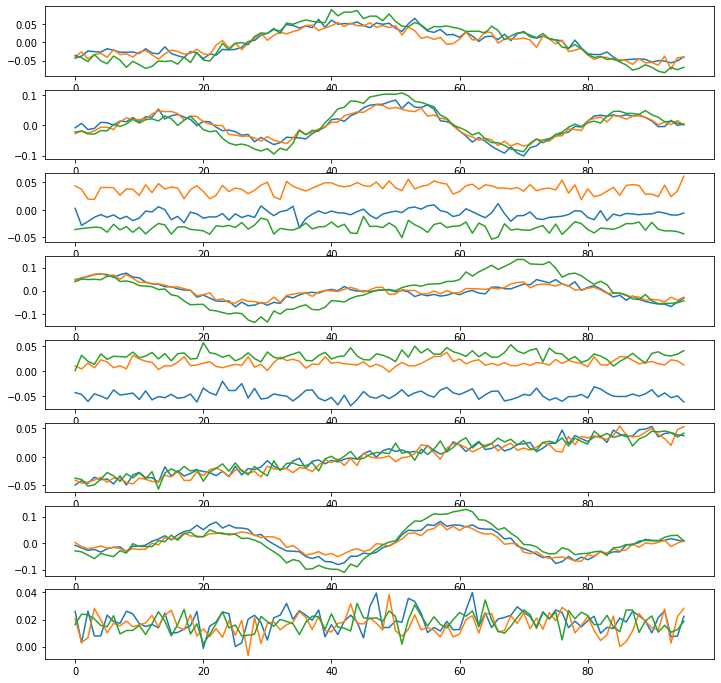

In [9]:
w1 = np.asarray(model1.weights[0])
ws1 = np.reshape(w1, (predict_length, nDims, n_hidden_units1))
print(ws1.shape)
fig, ax = plt.subplots(n_hidden_units1, 1, figsize=(12,12))
for h in range(n_hidden_units1):
  ax[h].plot(ws1[:,:,h])

#Model 2: Windowed PCA

One problem is that PCA will pay attention to the edges of the time window just as much as to the middle.  However, then it risks learning nothing because the middle has much more "rich" data.  We can use a window function to emphasize just the central part of the data for each sample.  In other words, train with $x_{t-N}^t * r$ where $r$ is a 288-element vector that is zero except for a Gaussian centered on the middle time.  We will do this first for the case of univariate data; just using a single channel of the 3 channel input.  

We can't use timeseriesgenerator for this (without subclassing), so will just do it the hard brute force way and generate the data as a matrix, reshaped from the original.


In [10]:
ch1 = dfMic[1].values
ln = predict_length * int(len(ch1)/predict_length)
ln -= predict_length  #for safety
#turn into blocks of predict_length data points
x2 = np.reshape(ch1[:ln], (-1,predict_length))
np.testing.assert_equal(ch1[0:predict_length], x2[0,:])  #check that reshape worked correctly

#calculate for all the other offsets and add those too (out of order)
for offset in range(1,predict_length):
  x2 = np.concatenate((x2,np.reshape(ch1[offset:ln+offset], (-1,predict_length))))

#make a gaussian window
win = np.linspace(-2,2, predict_length)
win = np.exp(-win * win)
win = win / np.sum(win)

#apply the window to the data
y2 = win * x2  

Why apply the window only to the output $y$?  The reason is that if you apply it to both the input and the output, then the weights from the edges of the window can be arbitrary.  Since the input and target output are always zero in this region, the weights don't matter.  But if we want the weights to actually learn that we are ignoring this region, then we can apply just to the ouput and train the "autoencoder" (which is no longer a true autoencoder) to learn that the values of the output near the edges should be zero.  Now the network will learn this and set the weights near the edges to zero.  This will be done in the decoder of course, but it will also be done in the encoder because the values near the edges are not needed for decoding and thus should not be included in the hidden units.

Model: "model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96)]              0         
                                                                 
 encode (Dense)              (None, 8)                 776       
                                                                 
 decode (Dense)              (None, 96)                864       
                                                                 
Total params: 1,640
Trainable params: 1,640
Non-trainable params: 0
_________________________________________________________________


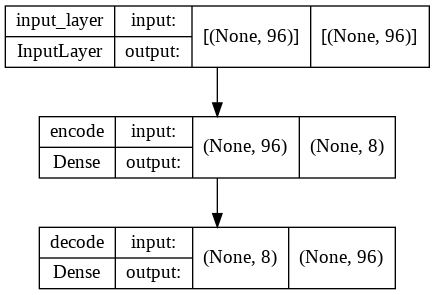

In [11]:
#build a simple linear autoencoder network
n_hidden_units2 = 8 
batch_size = 10

input_layer = Input(shape=(predict_length), name='input_layer')
encode_layer = Dense(units=n_hidden_units2, activation='linear', name='encode')(input_layer)
decode_layer = Dense(units=predict_length, activation='linear', name='decode')(encode_layer)
output_layer = decode_layer

#here we use the regular keras.Model because we will set the output manually
model2 = Model(inputs = input_layer, outputs = output_layer, name ='model2')  #have to explicitly tell it the inputs and outputs
model2.compile(optimizer='adam', loss='mse')
model2.summary()
plot_model(model2, show_shapes = True, show_layer_names = True)

Epoch 1/5
9984/9984 [==============================] - 17s 2ms/step - loss: 0.0010
Epoch 2/5
9984/9984 [==============================] - 17s 2ms/step - loss: 1.6229e-05
Epoch 3/5
9984/9984 [==============================] - 17s 2ms/step - loss: 1.3391e-05
Epoch 4/5
9984/9984 [==============================] - 17s 2ms/step - loss: 1.2815e-05
Epoch 5/5
9984/9984 [==============================] - 17s 2ms/step - loss: 1.2668e-05


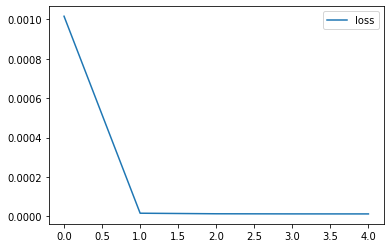

In [12]:
#we have created the outputs that we want; do not have to use the AutoEncoderModel
model2.fit(x2,y2,epochs=5, batch_size = batch_size)
losses = pd.DataFrame(model2.history.history)
losses.plot()

Show the learned encoder.  Each of the hidden units is an FIR filter.  This will display the impulse response for each of these filters.  For pink noise (lowpass filtered white noise) the eigenvectors look like Gabor filters; the product of a Gaussian envelope and a sinusoid $g(t)\sin (\omega t + \phi)$ where $g(t)$ is a Gaussian envelope and $\phi$ is a phase.  Usually only two phases are needed per frequency $\omega$ to capture the sin and cos components.

Fun fact:  Gabor filters minimize the product of time-domain and frequency-domain width.  In other words, the product of the half-width (variance) of $g(t)$ and the the half-width of the Fourier transform $f(\omega)$ achieves the theoretical minimum.  The proof is similar to the proof of the Heisenberg uncertainty principle which states that there is a lower limit on the accuracy with which position and momentum can both be measured.  This limit is the product of the position accuracy and the momentum accuracy.  In the Gabor filter case, frequency takes the role of momentum (energy), and temporal precision takes the role of spatial precision.

The resulting filters resemble wavelets, although typically wavelets are chosen to be self-similar across scales, which means that if you double the frequency of the sin wave you should halve the width of the Gaussian so the shape stays the same at the smaller scale.  This will not happen here because the window width is fixed.  If we chose different window widths for training each of the hidden units, we could potentially learn a wavelet decomposition.

(96, 8)


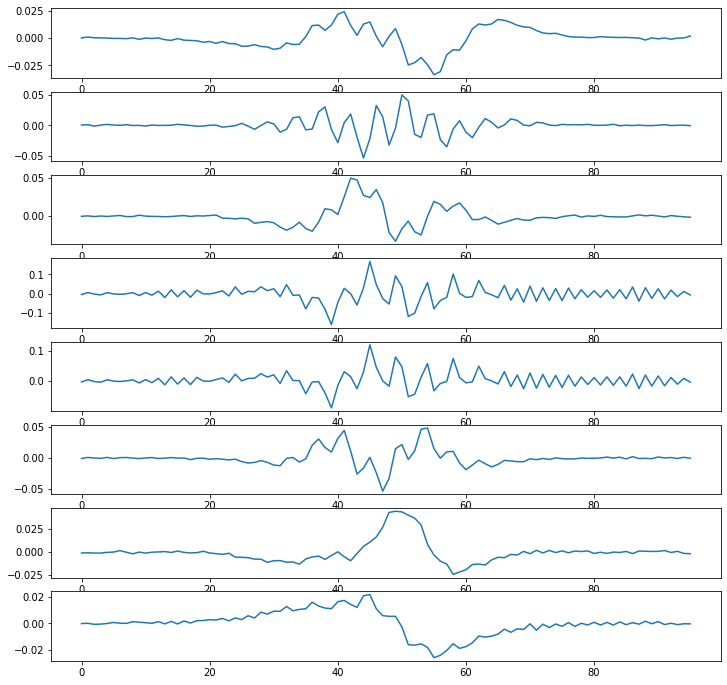

In [13]:
ws2 = np.asarray(model2.weights[0])
print(ws2.shape)
fig, ax = plt.subplots(n_hidden_units2, 1, figsize=(12,12))
for h in range(n_hidden_units2):
  ax[h].plot(ws2[:,h])
  #ax[h].plot(win *ws2[:,h])

#Model 3: Multivariate windowed nonlinear PCA

Here we do almost exactly the same thing as in model2, except we use all 3 channels of the input, and apply the Gaussian window to each.

To make this more interesting, we will use a nonlinear polynomial basis to do something like a Volterra expansion on the hidden units, and then do PCA again to find nonlinear features of the input.

In other words, suppose the input is $x(t)$ which is actually a 96x3=288 element vector at each time t.  We compress this to a 20 element vector $y(t) = Wx(t)$ where the columns of $W$ are the first $M$ eigenvectors of $E[xx^T]$.  Then we form all possible combinations of $y_i(t)y_j(t)$ which can be done by flattening the matrix $yy^T$, to get the 2nd order Taylor series.  We use the same code we did for the Volterra expansion back in Lecture 3, but this is not technically a true Volterra expansion because we are operating on the eigenvector compressed data, rather than on the time-lagged data.  Let $z(t)$ be the expansion of $y$ in cross products, so that for 2nd-order terms we have $z(t) = \sigma[y] =  <1; y_i , i\in(0,M); y_iy_j , i,j \in (0,M)>$ where $\sigma $ stands for the Volterra expansion.  $z$ has 421 elements (20x20 + 20 + 1), and we compress this with another PCA down to 50 elements using $U$ where the columns of $U$ are the first 50 eigenvectors of $E[zz^T]$.  

Now the output of this network is $Uz = U \cdot \sigma[Wx]$ which looks like a two-layer nonlinear network.  But note that we did not train this with deep learning (backpropagation) but rather using just PCA at each layer.  

The combination of a nonlinear expansion layer $\sigma$ followed by a linear compression layer $U$ is called "kernel PCA" and there are some nice simplifications that can be done in the case the $\sigma$ represents radial basis functions centered on the training data. The basic theory of nonlinear PCA goes as follows:

Suppose that we have a set of functions $\{ f_i \}$ that are themselves linear combinations of a set of basis functions $\{ \sigma_j \}$ such that $f_i(x) = \sum_j \alpha_{ij}\sigma_j(x)$.  The set of $\sigma$'s can be infinite, so this describes the case of Fourier transforms (where the $\sigma$'s are sin's and cos's and cross products of terms in $x$) and analytic functions (where the $\sigma$'s are powers and cross-products of the terms in $x$). So this is very general, and any function $f_i$ can be described by its coefficients (transform) $\alpha_{ij}$. 

Now suppose we want to find a smaller finite basis set $\phi_k(x)$ such that we can approximate $f_i(x) \approx \hat{f}_i(x) =  \sum_k \beta_{ik} \phi_k(x)$.  It won't be perfect, because there is only a finite basis set instead of an infinite set.  If we want to minimize the mean squared error $E_{ix}[(f_i(x)-\hat{f}_i(x))^2]$ then, you guessed it, the answer is that the $\phi_k(x)$'s need to be in some sense the PCA of the $\sigma_j(x)$'s.  What this means is that we can write each of the new basis in terms of the old basis: $\phi_k(x) = \sum_j \gamma_{kj} \sigma_j(x)$, and the optimal solution is when the $\gamma_k$'s span the space of the first $M$ eigenvectors of $E_x[\sigma(x)\sigma(x)^T]$.  Note that this is the covariance matrix of the **outputs** of the nonlinear transformation, and it may have much higher dimensionality than the covariance matrix of $x$. 

There is another factor that is needed here in the event that we know something about the set of possible functions $f$, but let's assume for now that all output functions are equally likely.  I will include a paper that goes through all the math on this.


In [14]:
#make a gaussian window
win = np.linspace(-2,2, predict_length)
win = np.exp(-win * win)
win = win / np.sum(win)

#put all 3 channels together
for c in range(nDims):
  ch = dfMic[c].values
  ln = predict_length * int(len(ch)/predict_length)
  ln -= predict_length  #for safety
  #turn into blocks of predict_length data points
  xc = np.reshape(ch[:ln], (-1,predict_length))
 
  #calculate for all the other offsets and add those to the end
  for offset in range(1,predict_length):
    xc = np.concatenate((xc,np.reshape(ch[offset:ln+offset], (-1,predict_length))))

  #apply the window to this channel
  yc = win * xc  

  #concatenate horizontally for each of the input axes
  if c==0:
    x3 = xc
    y3 = yc
  else:
    x3 = np.concatenate((x3,xc), axis=1)
    y3 = np.concatenate((y3,yc), axis=1)


Model: "model3a"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 288)]             0         
                                                                 
 encode (Dense)              (None, 20)                5780      
                                                                 
 decode (Dense)              (None, 288)               6048      
                                                                 
Total params: 11,828
Trainable params: 11,828
Non-trainable params: 0
_________________________________________________________________


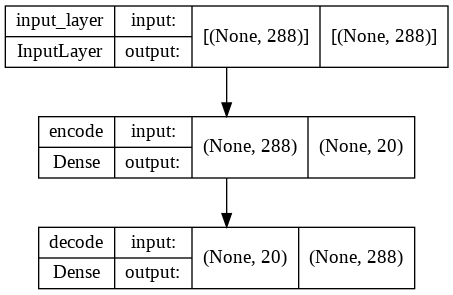

In [15]:
#autoencoder network to compress the 96x3 flattened input data
n_hidden_units3a = 20

input_layer = Input(shape=(predict_length*nDims), name='input_layer')
encode_layer = Dense(units=n_hidden_units3a, activation='linear', name='encode')(input_layer)
decode_layer = Dense(units=predict_length*nDims, activation='linear', name='decode')(encode_layer)
output_layer = decode_layer

model3a = Model(inputs = input_layer, outputs = output_layer, name ='model3a')  #have to explicitly tell it the inputs and outputs
model3a.compile(optimizer='adam', loss='mse')
model3a.summary()
plot_model(model3a, show_shapes = True, show_layer_names = True)

Epoch 1/5
9984/9984 [==============================] - 18s 2ms/step - loss: 4.2374e-04
Epoch 2/5
9984/9984 [==============================] - 18s 2ms/step - loss: 1.8487e-05
Epoch 3/5
9984/9984 [==============================] - 19s 2ms/step - loss: 1.5084e-05
Epoch 4/5
9984/9984 [==============================] - 18s 2ms/step - loss: 1.4847e-05
Epoch 5/5
9984/9984 [==============================] - 18s 2ms/step - loss: 1.8263e-05


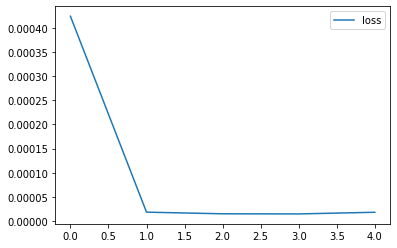

In [16]:
model3a.fit(x3,y3,epochs=5, batch_size = 10)
losses = pd.DataFrame(model3a.history.history)
losses.plot()

Because we have concatenated each of the 3 channels, the weights to each hidden unit will include the impulse responses from each of the 3 inputs.

So far we have found the $W$ matrix that creates the first layer $y=Wx$.

(288, 20)


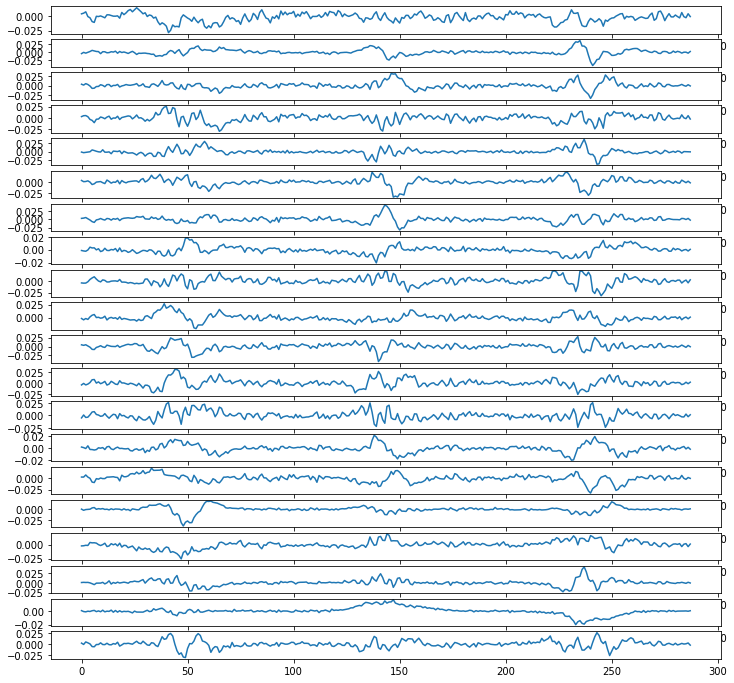

In [17]:
ws3 = np.asarray(model3a.weights[0])
print(ws3.shape)
fig, ax = plt.subplots(n_hidden_units3a, 1, figsize=(12,12))
for h in range(n_hidden_units3a):
  ax[h].plot(ws3[:,h])

Here is a function to generate the Volterra expansion of a vector.  If this vector is lagged timevalues $x(t) \ldots x(t-N)$ then this is a true Volterra expansion.  Otherwise it is just a polynomial expansion.  But the code is the same.

In [18]:
def volterraExpand(data, volterra_order):
  nData, volterra_memory = data.shape

  #calculate the length of the kernel.  1(constant term) + memory(linear term) + memory^2 in this case 
  filter_length = 1
  for n in range(1, volterra_order+1):
    filter_length = filter_length + volterra_memory**n
  y = np.zeros((nData, filter_length))  #set the first ones to zero so outputs line up

  #now run the volterra kernel over the input to generate the output
  for t in range(0,nData):
      xt = data[t,:] 
      xn = [1]  #constant term in volterra expansion
      inp = [1]
      for n in range(1,volterra_order+1):  #loop over the power (order) of volterra terms
        xn = np.outer(xn,xt).ravel()    #this creates all the products x(t-i)x(t-j)...x(t-w) for the n'th order term
        inp = np.append(inp,xn)        #include all the terms, constant+linear+secondorder+...
                                      #each term has length volterra_memory**n including all possible cross-products
      y[t,:] = inp 
  
  return y


In [19]:
#filter the original data with the linear encoder weights to get y=Wx
x3a = x3 @ ws3

#now build a set of volterra kernels on these
# in this case, volterra_memory will be the number of linear components from the encoder
volterra_order = 2   #maximum polynomial order; more than 2 is usually unwieldy
                    #note that volterra_order=1 just gives a linear filter
xv = volterraExpand(x3a, volterra_order)  #this is sigma[y] = sigma[Wx]

scaler2 = StandardScaler()
scaler.fit(xv)  #use only the sliced data for the fit
x3b = scaler.transform(xv)  #from here on we use only the sliced data

x3b[:,1]=1  #keep the constant term
nt, n_volterra_inputs = x3b.shape
print(x3b.shape)


(99840, 421)


So far we have calculated $\sigma[Wx]$.  We have done the first linear layer, followed by the nonlinear expansion layer.  Next we will learn a PCA reduction of the expansion layer, to obtain $U \cdot \sigma[Wx]$. 

Model: "model3b"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 421)]             0         
                                                                 
 encode (Dense)              (None, 50)                21100     
                                                                 
 decode (Dense)              (None, 421)               21471     
                                                                 
Total params: 42,571
Trainable params: 42,571
Non-trainable params: 0
_________________________________________________________________


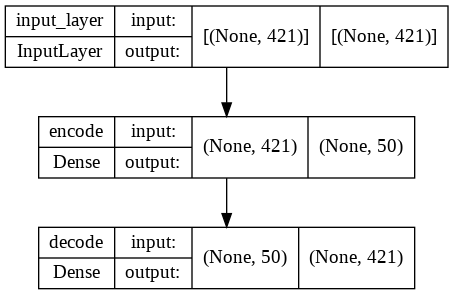

In [20]:
#build a simple linear autoencoder network on top of the volterra expasnsion
n_hidden_units3b = 50 

input_layer = Input(shape=(n_volterra_inputs), name='input_layer')
encode_layer = Dense(units=n_hidden_units3b, activation='linear', name='encode')(input_layer)
decode_layer = Dense(units=n_volterra_inputs, activation='linear', name='decode')(encode_layer)
output_layer = decode_layer

model3b = Model(inputs = input_layer, outputs = output_layer, name ='model3b')  #have to explicitly tell it the inputs and outputs
model3b.compile(optimizer='adam', loss='mse')
model3b.summary()
plot_model(model3b, show_shapes = True, show_layer_names = True)

Epoch 1/5
9984/9984 [==============================] - 21s 2ms/step - loss: 0.2884
Epoch 2/5
9984/9984 [==============================] - 21s 2ms/step - loss: 0.2571
Epoch 3/5
9984/9984 [==============================] - 20s 2ms/step - loss: 0.2571
Epoch 4/5
9984/9984 [==============================] - 20s 2ms/step - loss: 0.2569
Epoch 5/5
9984/9984 [==============================] - 20s 2ms/step - loss: 0.2586


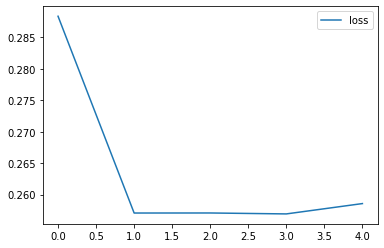

In [21]:
model3b.fit(x3b,x3b,epochs=5, batch_size = 10)
losses = pd.DataFrame(model3b.history.history)
losses.plot()

In [22]:
#apply volterra encoder to volterra data to get U sigma[Wx]
wvs = np.asarray(model3b.weights[0])
print(wvs.shape)
x_volterra_encoded = x3b @ wvs
nt, n_volterra_encoded = x_volterra_encoded.shape
print(x_volterra_encoded.shape)


(421, 50)
(99840, 50)


#Model 4: Supervised learning on top of the nonlinear PCA basis

Now that we have learned our "optimal" nonlinear basis $U \cdot \sigma[Wx]$, let's use it to do something supervised.  All we have to do is learn a single linear top layer to obtain $b \approx A\cdot U \cdot \sigma[Wx]$.  We do not have to do any deep training at all, and in fact $A$ could be learned by linear regression.  But I will use another network here just for practice.

The target output will be to predict 3 additional channels of brain data, taken from a group of 3 electrodes 5mm away from the originals.  The goal is to see how much one brain region predicts another.  One problem is that, just like the original 3 electrodes, there are significant correlations on the new target ones.  To address this, we PCA transform the 3 target electrodes which will put all the correlations on a single channel, and that may allow the predictions to concentrate on the separate components seen at the new brain site.

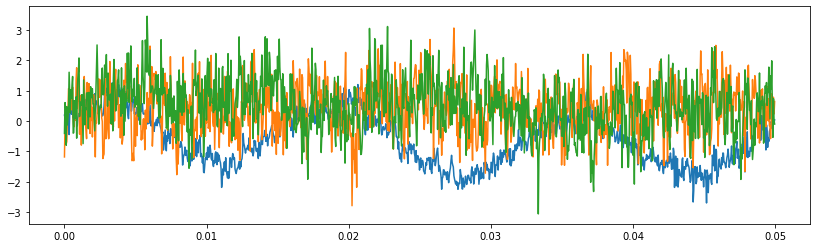

In [23]:
#load more sample Brain data (as before, you have to copy micro456.csv to your google drive)
#3 channels from GPi, each in microvolts.  sampling at 24.414kHz
micro456 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/micro456.csv', names=['ch4','ch5','ch6'])
nDims456=3
samplingFrequency = 24414
nPoints = len(micro456)
np.testing.assert_equal(nPoints, len(micro123))
maxTime = nPoints/samplingFrequency
ts_index = np.linspace(start= 0 ,stop=maxTime, num= nPoints)

#eigenvector transform the data to remove correlations
w,v = np.linalg.eig(micro456.T @ micro456)
micro456 = micro456 @ v

#scale the range.  scale separately for each of the data channels
scaler2 = StandardScaler()
scaler2.fit(micro456)  
micro456_scaled = scaler2.transform(micro456)  

micro456_scaled = micro456_scaled[int(predict_length/2):,:]  #shift so we predict the point in the middle
micro456_scaled = micro456_scaled[:len(x_volterra_encoded),:]  #has to be the same length as the predicting dataset
dfMic456 = pd.DataFrame(micro456_scaled, index = ts_index[:len(x_volterra_encoded)])

plt.figure(figsize=(14,4))
plt.plot(dfMic456[0:.05]);

The sinusoidal noise (probably 60Hz) is present in all 3 of the original channels, but PCA concentrates this all on one channel for us.  We can still try to predict it, in the event that similar noise is present on the source channels.

Now we will learn the $A$ matrix by standard supervised learning.  This is just a single-layer linear network.

Model: "model4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 50)]              0         
                                                                 
 encode (Dense)              (None, 3)                 153       
                                                                 
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________


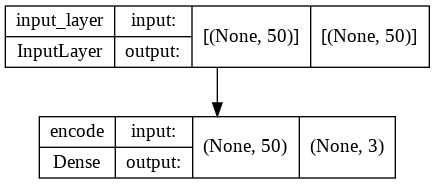

In [24]:
#build a simple linear network on top of the volterra compression

input_layer = Input(shape=(n_volterra_encoded), name='input_layer')
fit_layer = Dense(units=nDims456, activation='linear', name='encode')(input_layer)
output_layer = fit_layer

model4 = Model(inputs = input_layer, outputs = output_layer, name ='model4')  #have to explicitly tell it the inputs and outputs
model4.compile(optimizer='adam', loss='mse')
model4.summary()
plot_model(model4, show_shapes = True, show_layer_names = True)

In [25]:
print(x_volterra_encoded.shape)
print(micro456_scaled.shape)

(99840, 50)
(99840, 3)


Epoch 1/5
9984/9984 [==============================] - 15s 2ms/step - loss: 1.2074
Epoch 2/5
9984/9984 [==============================] - 15s 1ms/step - loss: 1.0141
Epoch 3/5
9984/9984 [==============================] - 15s 2ms/step - loss: 1.0143
Epoch 4/5
9984/9984 [==============================] - 15s 2ms/step - loss: 1.0147
Epoch 5/5
9984/9984 [==============================] - 15s 2ms/step - loss: 1.0149


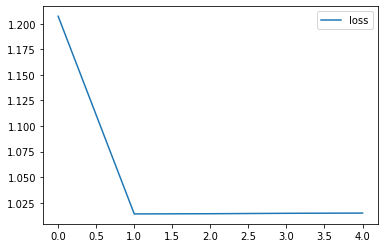

In [26]:
model4.fit(x_volterra_encoded, micro456_scaled,epochs=5, batch_size = 10)
losses = pd.DataFrame(model4.history.history)
losses.plot()

In [27]:
#calculate the predicted outputs.  This gives A*U*sigma[Wx]
micro456_predict = model4.predict(x_volterra_encoded)

The predicted outputs $a = A U \sigma[Wx]$ are a nonlinear function of the inputs $x$.  To really solve this problem, we would need to look at different time delays (for now we are predicting the $a(t)$ in the middle of the input window), different window functions, different nonlinear transforms $\sigma$, and different numbers of hidden units.  

Output 0 has r 0.0013 and p 0.6804
Output 1 has r 0.0058 and p 0.0666
Output 2 has r 0.0044 and p 0.1627


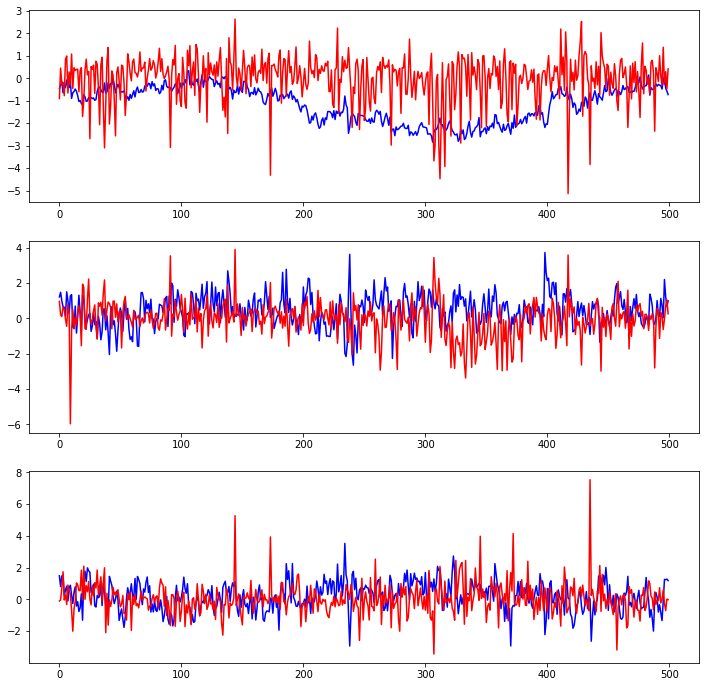

In [28]:
scaler3 = StandardScaler()
scaler3.fit(micro456_predict)  
micro456_predict_scaled = scaler3.transform(micro456_predict)  

fig,ax=plt.subplots(nDims456,1,figsize=(12,12))
t1 = 2000
t2 = 2500
for s in range(nDims456):
  ax[s].plot(micro456_scaled[t1:t2,s],'b')
  ax[s].plot(micro456_predict_scaled[t1:t2,s],'r')
  slope, intercept, r_value, p_value, std_err = sp.stats.linregress(micro456_scaled[:,s], micro456_predict_scaled[:,s])
  print("Output %d has r %.4f and p %.4f" % (s, r_value, p_value))
  


#Homework 8

The above demonstration used unsupervised learning to find a set of features without knowing what the target (micro456) was going to be. These features are thus more general and could apply to many different things, but are not as good as if we had just learned a network with supervised learning. Your homework is to do the comparison with supervised learning:

Create a multilayer nonlinear encoder network with 20 hidden units in the middle layer, but at least 3 nonlinear layers below and above the hidden layer, as we did in Model4 from Lecture11.  Use x3 (from above) as inputs to the network, and micro456_scaled as the target outputs.  Calculate the r values and compare with the network above.